In [1]:
#import libraries
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from splot.mapping import vba_choropleth, vba_legend, mapclassify_bin
from shapely.geometry import Point, Polygon, LineString
import libpysal.weights as sw 
from esda.moran import Moran_Local, Moran
from splot.esda import lisa_cluster, plot_local_autocorrelation, plot_moran
import warnings
warnings.simplefilter("ignore") 

In [2]:
#NOTE: The first part is a test of the steps taken for use in the final class

In [3]:
#read and filter the shapefiles according to county(tracts) and by landuse (parks2)
#clean nyc_parks data to correct the columns, and make a column 'GEOID' that can be used to merge with the tract data
parks2=gpd.read_file('S:/376/Spring22/jkchap16/nyc_parks.zip')
parks2=parks2.to_crs(epsg='4269')

In [4]:
parks2['landuse'].value_counts()

Parkway                        865
Flagship Park                  566
Jointly Operated Playground    494
Community Park                 473
Neighborhood Park              441
Mall                           390
Playground                     340
Garden                         279
Triangle/Plaza                 260
Nature Area                    199
School Yard to Playground      192
Recreation Field/Courts        138
Undeveloped                     79
Buildings/Institutions          39
Strip                           38
Waterfront Facility             28
Tracking                        27
Retired N/A                     21
Historic House Park             15
Cemetery                        12
Lot                             10
Tracking Only                    6
<Null>                           2
LARGE PARK AREA                  1
EventArea                        1
Name: landuse, dtype: int64

In [5]:
parks3=parks2[(parks2['landuse']=='Neighborhood Park') | (parks2['landuse']=='Community Park') |(parks2['landuse']=='Nature Area') |(parks2['landuse']=='Garden') | (parks2['landuse']=='Flagship Park')]

In [6]:
tracts=gpd.read_file('S:/376/Spring22/jkchap16/nyc_tract.zip')
nyc_acs=pd.read_csv('S:/376/Spring22/jkchap16/nyc_race.csv')

In [7]:
stat_tracts=tracts[tracts['COUNTYFP']=='061']

In [8]:
nyc_acs.columns=nyc_acs.iloc[0]
nyc_acs['GEOID']= nyc_acs['id'].str.split('US').str[1]
nyc_acs=nyc_acs.iloc[1:]
nyc_acs.head()

,Estimate!!Total:,Margin of Error!!Total:,Estimate!!Total:!!White alone,Margin of Error!!Total:!!White alone,Estimate!!Total:!!Black or African American alone,Margin of Error!!Total:!!Black or African American alone,Estimate!!Total:!!American Indian and Alaska Native alone,Margin of Error!!Total:!!American Indian and Alaska Native alone,Estimate!!Total:!!Asian alone,Margin of Error!!Total:!!Asian alone,...,Margin of Error!!Total:!!Some other race alone,Estimate!!Total:!!Two or more races:,Margin of Error!!Total:!!Two or more races:,Estimate!!Total:!!Two or more races:!!Two races including Some other race,Margin of Error!!Total:!!Two or more races:!!Two races including Some other race,"Estimate!!Total:!!Two or more races:!!Two races excluding Some other race, and three or more races","Margin of Error!!Total:!!Two or more races:!!Two races excluding Some other race, and three or more races",id,Geographic Area Name,GEOID
1,6600,684,2560,288,3441,430,27,27,171,69,...,177,149,74,44,41,105,55,1400000US36005000100,"Census Tract 1, Bronx County, New York",36005000100
2,4167,713,1272,370,1394,477,0,12,115,105,...,517,304,259,203,241,101,94,1400000US36005000200,"Census Tract 2, Bronx County, New York",36005000200
3,5684,986,2185,434,1348,382,15,24,173,164,...,982,238,147,47,55,191,129,1400000US36005000400,"Census Tract 4, Bronx County, New York",36005000400
4,5917,719,1334,331,2353,504,192,224,76,107,...,474,426,243,351,234,75,62,1400000US36005001600,"Census Tract 16, Bronx County, New York",36005001600
5,1910,301,624,229,778,247,0,12,0,12,...,233,74,62,62,63,12,16,1400000US36005001901,"Census Tract 19.01, Bronx County, New York",36005001901


In [9]:
nyc_acs['percent_white'] = 100* (nyc_acs['Estimate!!Total:!!White alone'].astype('int')/nyc_acs['Estimate!!Total:'].astype('int'))
nyc_acs['percent_black'] = 100* (nyc_acs['Estimate!!Total:!!Black or African American alone'].astype('int')/nyc_acs['Estimate!!Total:'].astype('int'))
nyc_acs['percent_asian'] = 100* (nyc_acs['Estimate!!Total:!!Asian alone'].astype('int')/nyc_acs['Estimate!!Total:'].astype('int'))

In [10]:
#join parks and tracts to get the subset of parks in Specific area
stat_parks=gpd.sjoin(parks3, stat_tracts, op='intersects')

stat_parks

,feat_code,landuse,park_name,parknum,shape_area,shape_leng,source_id,status,sub_code,system,...,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON
10,4980.0,Community Park,Brooklyn Bridge Park,B431,1.995609e+06,18025.160510,2.149800e+10,Updated,498000.0,None,...,000500,36061000500,5,Census Tract 5,G5020,S,843918,3485553,+40.6906201,-074.0188321
10,4980.0,Community Park,Brooklyn Bridge Park,B431,1.995609e+06,18025.160510,2.149800e+10,Updated,498000.0,None,...,000900,36061000900,9,Census Tract 9,G5020,S,298886,476839,+40.6952363,-074.0018345
114,4980.0,Neighborhood Park,Battery Park,M005,5.418050e+04,1102.029789,2.149800e+10,Unchanged,498000.0,None,...,000900,36061000900,9,Census Tract 9,G5020,S,298886,476839,+40.6952363,-074.0018345
139,4980.0,Neighborhood Park,Battery Park,M005,1.299809e+04,460.895123,2.149800e+10,Unchanged,498000.0,None,...,000900,36061000900,9,Census Tract 9,G5020,S,298886,476839,+40.6952363,-074.0018345
11371,4910.0,Community Park,Brooklyn Bridge Park,B431,1.793353e+05,1769.927962,1.949100e+10,New,491050.0,None,...,000900,36061000900,9,Census Tract 9,G5020,S,298886,476839,+40.6952363,-074.0018345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6413,4980.0,Community Park,Riverside Park,M071,2.192564e+06,42928.750988,1.349800e+10,Unchanged,498000.0,None,...,022302,36061022302,223.02,Census Tract 223.02,G5020,S,60089,97199,+40.8208293,-073.9587889
6411,4980.0,Neighborhood Park,Riverside Park,M072,6.614203e+05,10647.728364,1.349800e+10,Unchanged,498000.0,None,...,022301,36061022301,223.01,Census Tract 223.01,G5020,S,186810,133262,+40.8221683,-073.9578271
6413,4980.0,Community Park,Riverside Park,M071,2.192564e+06,42928.750988,1.349800e+10,Unchanged,498000.0,None,...,015102,36061015102,151.02,Census Tract 151.02,G5020,S,223442,310785,+40.7745770,-073.9926715
6413,4980.0,Community Park,Riverside Park,M071,2.192564e+06,42928.750988,1.349800e+10,Unchanged,498000.0,None,...,015502,36061015502,155.02,Census Tract 155.02,G5020,S,111294,216066,+40.7788096,-073.9890168


<AxesSubplot:>

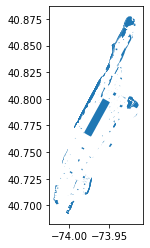

In [11]:
stat_parks.plot()

In [12]:
#make centroid and area columns and groupby name so that multipolygons are removed
stat_parks['area']=stat_parks.geometry.area
stat_parks['x_center']=stat_parks.geometry.centroid.x
stat_parks['y_center']=stat_parks.geometry.centroid.y
keys={'area': 'sum', 'x_center': 'mean','y_center': 'mean', 'shape_area':'mean'}
stat_parks=stat_parks.groupby('park_name', as_index=False).agg(keys)
stat_parks.reset_index(inplace=True)
stat_parks

,index,park_name,area,x_center,y_center,shape_area
0,0,110th Street Block Association Garden,2.188921e-08,-73.947328,40.796163,2208.126140
1,1,117th St Community Garden,3.360241e-08,-73.940582,40.798830,3389.587219
2,2,132 St Block Association Park,8.300984e-08,-73.943149,40.812313,8371.799943
3,3,5th St Slope Garden,4.006679e-08,-73.980859,40.723609,4046.191315
4,4,6BC Botanical Garden,7.789869e-08,-73.980674,40.723844,7866.664559
...,...,...,...,...,...,...
162,162,Wagner Houses Pool,6.779778e-07,-73.932606,40.801660,68386.975296
163,163,Washington Square Park,4.303122e-06,-73.997587,40.730884,434508.821798
164,164,West 111th St. People's Garden,5.207989e-08,-73.963552,40.803886,5253.075122
165,165,William B. Washington Memorial Garden,4.020120e-08,-73.951568,40.811418,4054.468791


In [13]:
#complete accessibility analysis based on euclidean distance from each tract to each park
#add the resulting accessibilities back to the tracts dataframe
A_euclid = []
for i in range(len(stat_tracts.centroid)):
    xo = stat_tracts.centroid.geometry.iloc[i].x
    yo = stat_tracts.centroid.geometry.iloc[i].y
    Ai_euclid = 0
    for j in range(len(stat_parks)):
        xd = stat_parks.x_center.iloc[j]
        yd = stat_parks.y_center.iloc[j]
        a = np.array((xo, yo))
        b = np.array((xd, yd))
        euclid_dist=np.linalg.norm(a-b)
        if euclid_dist > 0:
            Ai_euclid  += stat_parks['area'].iloc[j] / euclid_dist
            
    A_euclid.append(Ai_euclid)
        

In [14]:
stat_tracts['A_euclid']=A_euclid
stat_tracts

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,A_euclid
45,36,061,012700,36061012700,127,Census Tract 127,G5020,S,174025,0,+40.7622370,-073.9898561,"POLYGON ((-73.99316 40.76281, -73.99270 40.763...",0.053263
46,36,061,012800,36061012800,128,Census Tract 128,G5020,S,178794,0,+40.7713809,-073.9615172,"POLYGON ((-73.96432 40.77042, -73.96382 40.771...",0.073629
47,36,061,013000,36061013000,130,Census Tract 130,G5020,S,178225,0,+40.7727364,-073.9647332,"POLYGON ((-73.96753 40.77178, -73.96704 40.772...",0.086599
48,36,061,013300,36061013300,133,Census Tract 133,G5020,S,174355,0,+40.7647381,-073.9880352,"POLYGON ((-73.99133 40.76531, -73.99088 40.765...",0.057958
49,36,061,013400,36061013400,134,Census Tract 134,G5020,S,181768,0,+40.7717015,-073.9561657,"POLYGON ((-73.95918 40.77170, -73.95872 40.772...",0.063456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4893,36,061,025700,36061025700,257,Census Tract 257,G5020,S,144062,0,+40.8084355,-073.9540741,"POLYGON ((-73.95681 40.80755, -73.95634 40.808...",0.073791
4894,36,061,024200,36061024200,242,Census Tract 242,G5020,S,347358,135919,+40.8058563,-073.9335113,"POLYGON ((-73.93809 40.80635, -73.93764 40.806...",0.057037
4895,36,061,008603,36061008603,86.03,Census Tract 86.03,G5020,S,116894,153941,+40.7548017,-073.9634783,"POLYGON ((-73.96715 40.75277, -73.96703 40.752...",0.050137
5404,36,061,016900,36061016900,169,Census Tract 169,G5020,S,180003,0,+40.7851959,-073.9731196,"POLYGON ((-73.97644 40.78574, -73.97598 40.786...",0.095393


In [15]:
#merge to get acs data with the tracts
stat_tracts_acs=stat_tracts.merge(nyc_acs, on='GEOID')

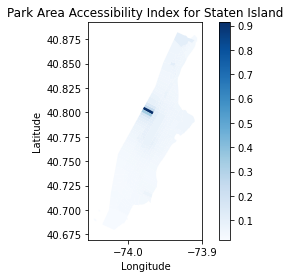

In [16]:
#plot normal choropleth
borough_name='Staten Island'
fig, ax=plt.subplots()
stat_tracts_acs.plot(ax=ax,column='A_euclid', cmap='Blues', alpha=1, legend=True)
plt.title('Park Area Accessibility Index for ' + borough_name)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()                   

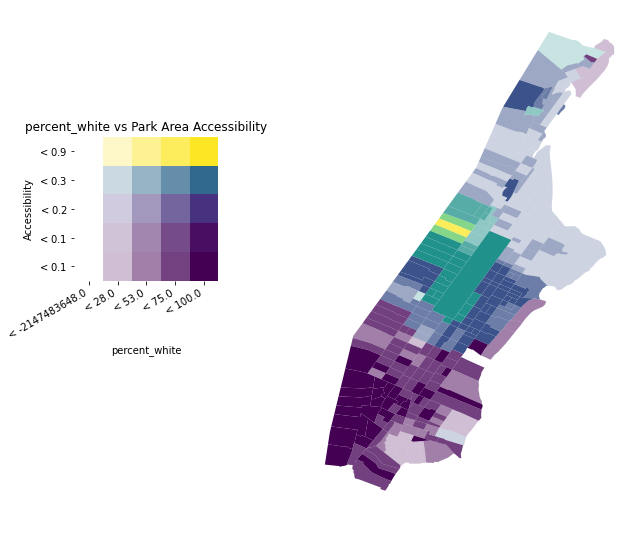

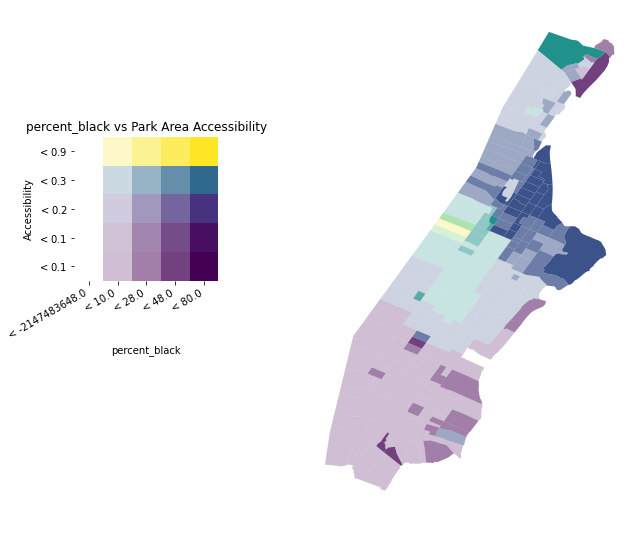

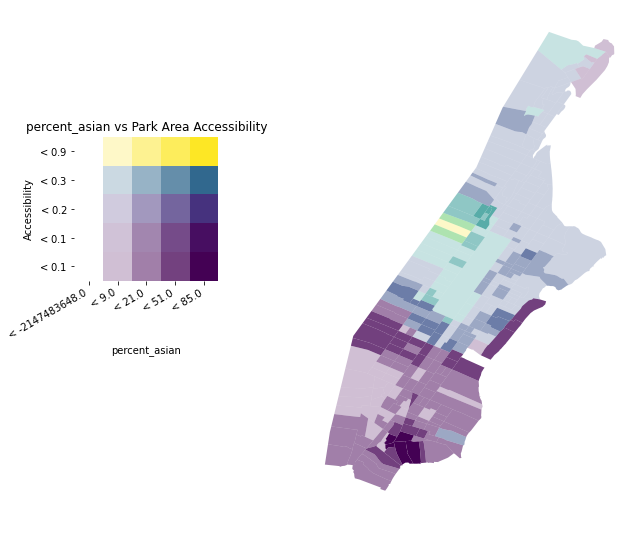

In [17]:
#use for loop to make bivariates of the accessibility and the percent of each demographic group
demos=['percent_white', 'percent_black', 'percent_asian']
for demo in demos:
    fig,ax=plt.subplots(figsize=(10,10))
    x=stat_tracts_acs['A_euclid'].values
    y=stat_tracts_acs[demo].values.astype('int')
    vba_choropleth(x, y, stat_tracts_acs,
            alpha_mapclassify=dict(classifier='natural_breaks', k=5),
            rgb_mapclassify=dict(classifier='natural_breaks', k=5),
            legend=True, ax=ax, cmap= 'viridis')
    plt.title(demo + ' vs Park Area Accessibility')
    plt.xlabel(demo)
    plt.ylabel('Accessibility')
    plt.show()

0.001 0.32025919366791133


(<Figure size 1080x288 with 3 Axes>,
 array([<AxesSubplot:title={'center':'Moran Local Scatterplot'}, xlabel='Attribute', ylabel='Spatial Lag'>,
        <AxesSubplot:>, <AxesSubplot:>], dtype=object))

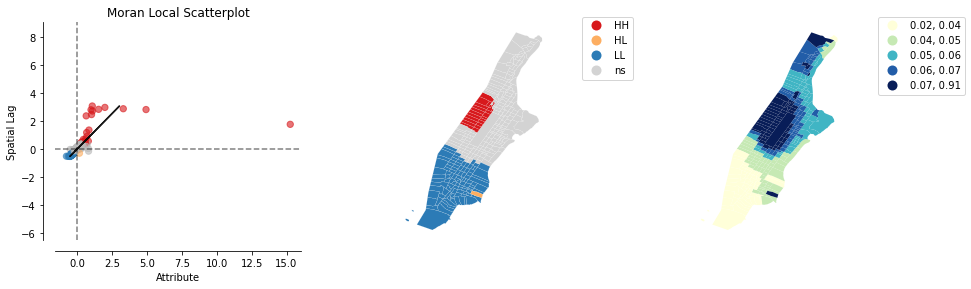

In [18]:
kw = sw.KNN.from_dataframe(stat_tracts_acs, k=10)
kw.transform='r'
m_value = Moran(stat_tracts_acs['A_euclid'].values, kw)
print(m_value.p_sim, m_value.I)
lisa=Moran_Local(stat_tracts_acs['A_euclid'].values, kw)
plot_local_autocorrelation(lisa, stat_tracts_acs, 'A_euclid')

In [19]:
# the county codes are 
codes={'manhattan':'061', 'staten_island':'085','bronx':'005', 'queens':'081', 'brooklyn':'047'}
print(codes)

{'manhattan': '061', 'staten_island': '085', 'bronx': '005', 'queens': '081', 'brooklyn': '047'}


In [20]:
#use cleaned versions of the files
class nyc_parks():
    
    #initiate variables
    def __init__(self, tracts, parks, acs):
        self.tracts=tracts
        self.parks=parks
        self.acs=acs
        
    #calculate euclidean accessiblility based on park area    
    def calc_accessibility(self, county_code):
        #filter to get boroughs and the parks in that borough
        self.city_tracts=self.tracts[self.tracts['COUNTYFP']==county_code]
        self.city_parks= gpd.sjoin(self.parks, self.city_tracts, op='intersects')
        self.city_parks['area']=self.city_parks.geometry.area
        self.city_parks['x_center']=self.city_parks.geometry.centroid.x
        self.city_parks['y_center']=self.city_parks.geometry.centroid.y
        keys={'area': 'sum', 'x_center': 'mean','y_center': 'mean'}
        self.city_parks=self.city_parks.groupby('park_name', as_index=False).agg(keys)
        self.city_parks.reset_index(inplace=True)
 
        #accessibility based on euclidean distance and park area
        A_euclid = []
        for i in range(len(self.city_tracts.centroid)):
            xo = self.city_tracts.centroid.geometry.iloc[i].x
            yo = self.city_tracts.centroid.geometry.iloc[i].y
            Ai_euclid = 0
            for j in range(len(self.city_parks)):
                xd = self.city_parks.x_center.iloc[j]
                yd = self.city_parks.y_center.iloc[j]
                a = np.array((xo, yo))
                b = np.array((xd, yd))
                euclid_dist=np.linalg.norm(a-b)
                if euclid_dist > 0:
                    Ai_euclid  += self.city_parks['area'].iloc[j] / euclid_dist
            
            A_euclid.append(Ai_euclid)
        
        self.city_tracts['A_euclid']=A_euclid
        #merge to get tract demographic info
        self.city_tracts_acs=self.city_tracts.merge(self.acs, on='GEOID')
    
    #plot basic choropleth map of accessibility scores
    def plot_accessibility(self, borough_name):
            fig, ax=plt.subplots()
            self.city_tracts_acs.plot(ax=ax,column='A_euclid', alpha=1, legend=True)
            plt.title('Accessibility index for ' + borough_name)
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.show()
        
    #plot bivariates with demographic groups and accessibility scores
    def plot_bivariate(self):
        demos=['percent_white', 'percent_black', 'percent_asian']
        for demo in demos:
            x=self.city_tracts_acs['A_euclid'].values
            y=self.city_tracts_acs[demo].values.astype('int')
            fig,ax=plt.subplots(figsize=(10,10))
            vba_choropleth(x, y, self.city_tracts_acs,
               alpha_mapclassify=dict(classifier='natural_breaks', k=4),
               rgb_mapclassify=dict(classifier='natural_breaks', k=4),
               legend=True, ax=ax, cmap= 'viridis')
            plt.title(demo + ' vs Park Area Accessibility')
            plt.xlabel(demo)
            plt.ylabel('Accessibility')
            plt.show()
            
    #calculate global and local moran's I using a distance-based weight matrix
    def moransI(self):
        kw = sw.KNN.from_dataframe(self.city_tracts_acs, k=10)
        kw.transform='r'
        m_value = Moran(self.city_tracts_acs['A_euclid'].values, kw)
        print(m_value.p_sim, m_value.I)
        lisa=Moran_Local(self.city_tracts_acs['A_euclid'].values, kw)
        plot_local_autocorrelation(lisa, self.city_tracts_acs, 'A_euclid')
        plt.show()
        

In [21]:
man=nyc_parks(tracts, parks3, nyc_acs)

In [22]:
man.calc_accessibility('061')

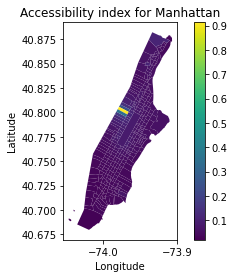

In [23]:
man.plot_accessibility('Manhattan')

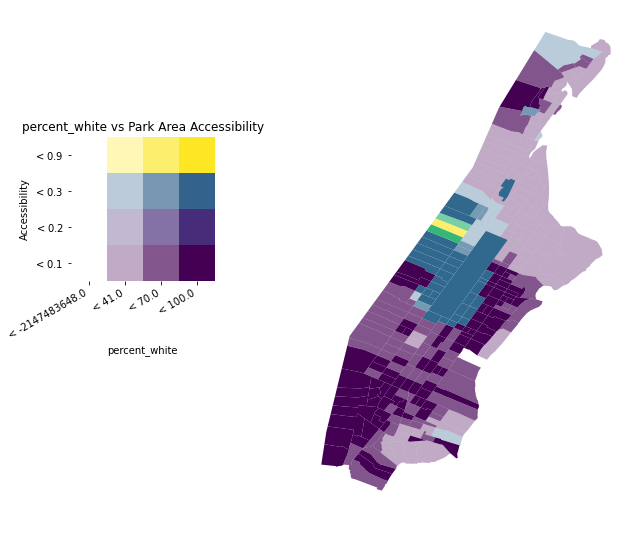

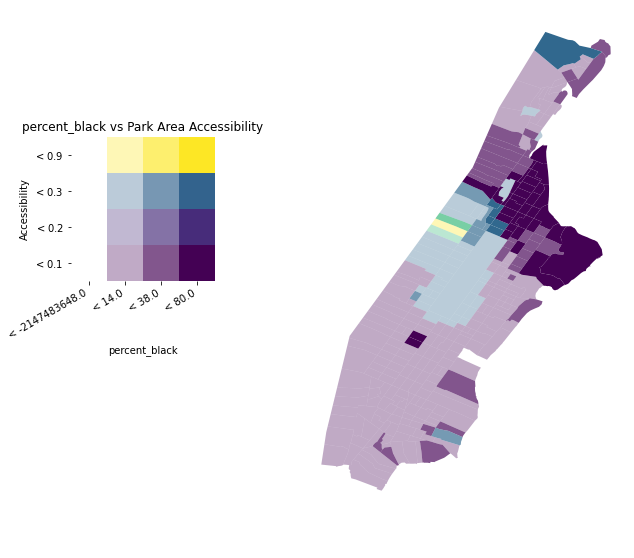

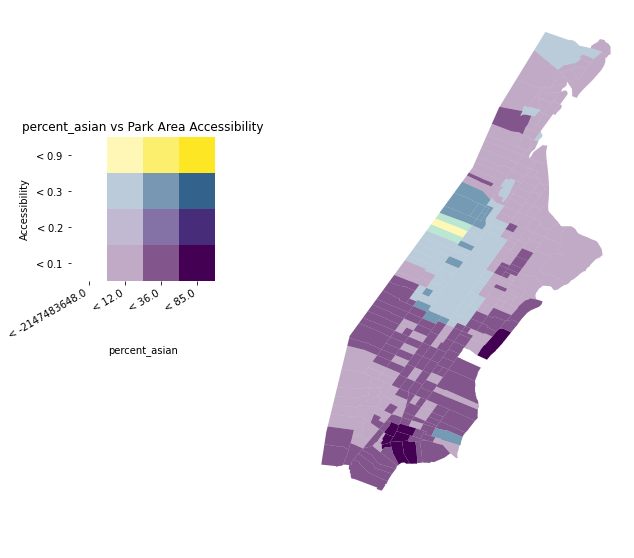

In [24]:
man.plot_bivariate()

0.001 0.32025919366791133


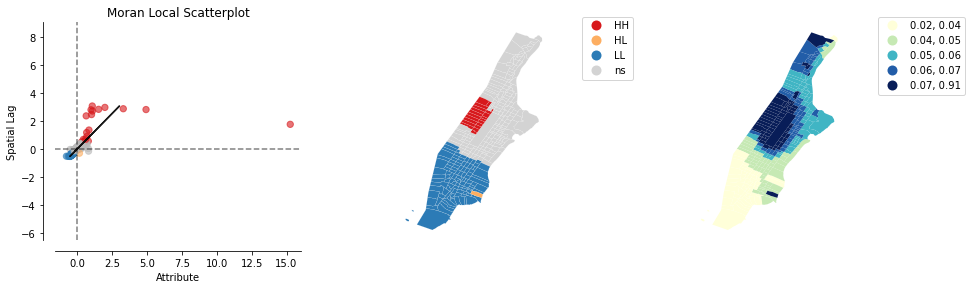

In [25]:
man.moransI()

In [26]:
brook=nyc_parks(tracts, parks3, nyc_acs)

In [27]:
brook.calc_accessibility('047')

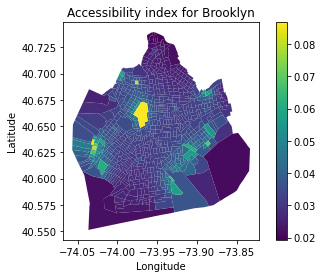

In [28]:
brook.plot_accessibility('Brooklyn')

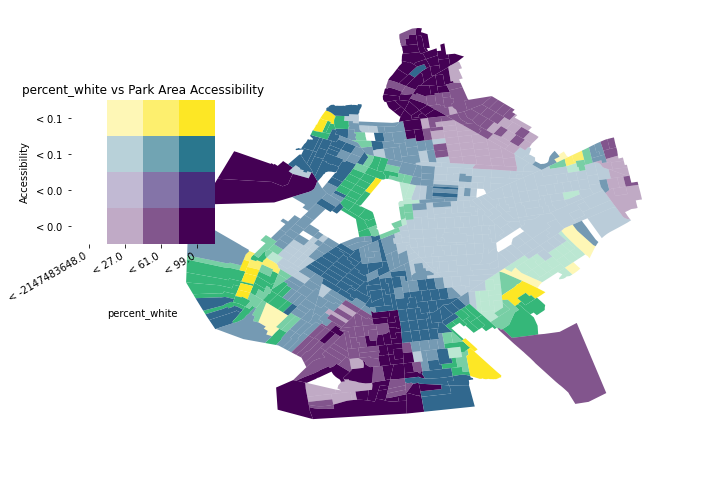

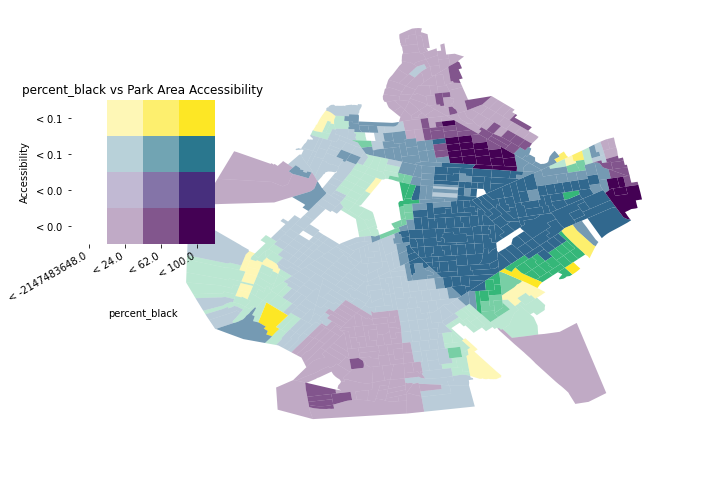

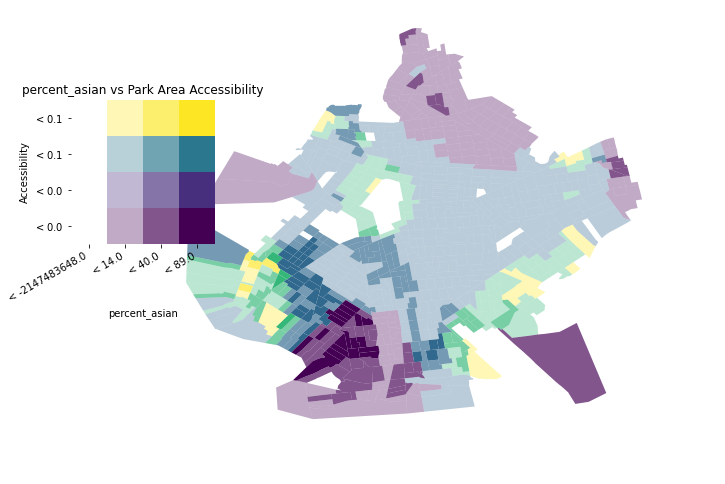

In [29]:
brook.plot_bivariate()

0.001 0.6736684202358356


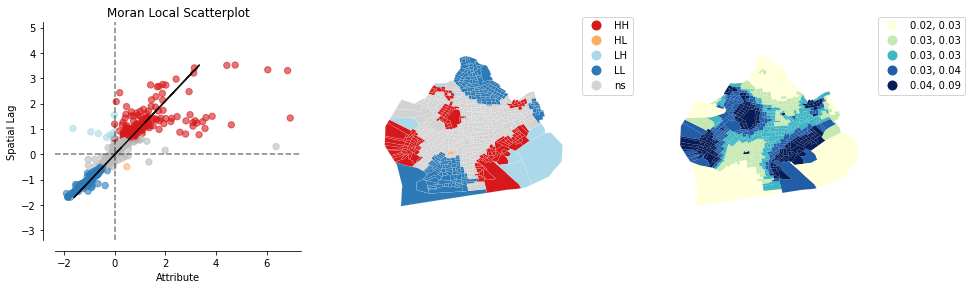

In [30]:
brook.moransI()

In [31]:
bronx=nyc_parks(tracts, parks3, nyc_acs)

In [32]:
bronx.calc_accessibility('005')

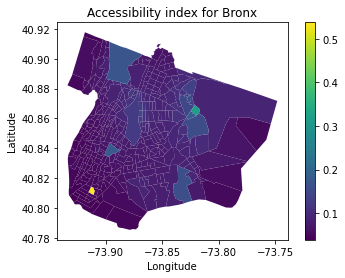

In [33]:
bronx.plot_accessibility('Bronx')

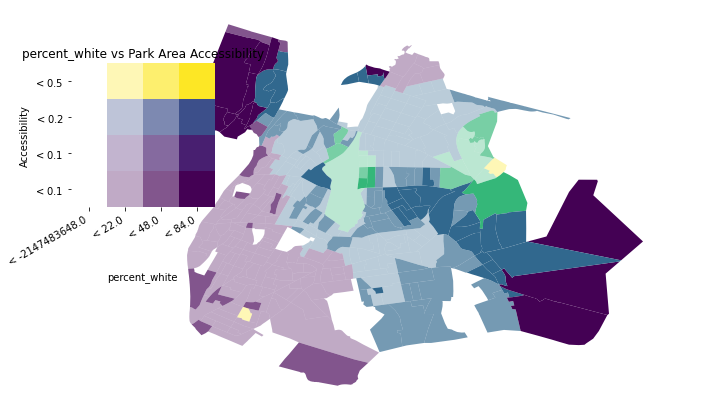

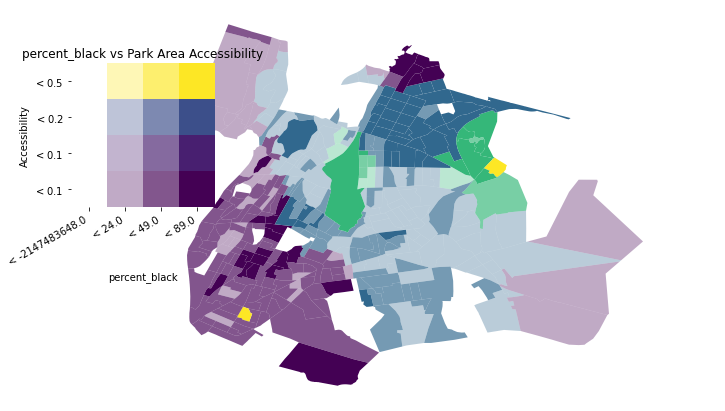

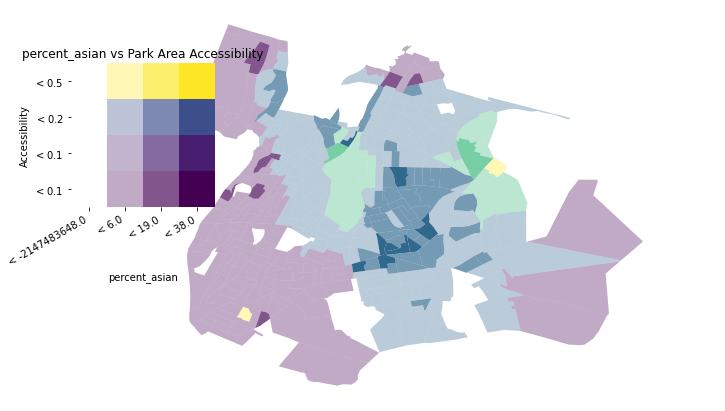

In [34]:
bronx.plot_bivariate()

0.001 0.25378641092800297


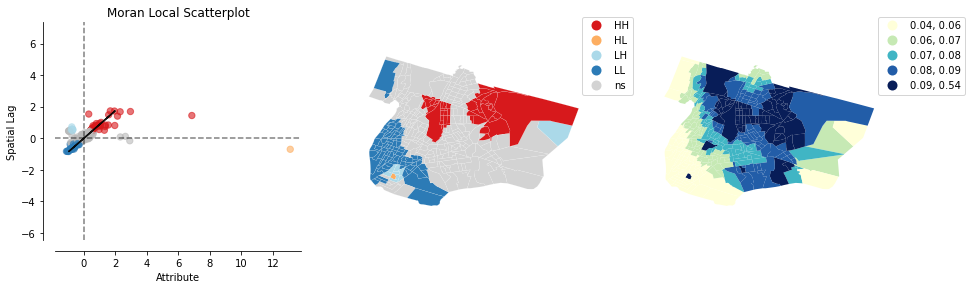

In [35]:
bronx.moransI()

In [36]:
staten=nyc_parks(tracts, parks3, nyc_acs)

In [37]:
staten.calc_accessibility('085')

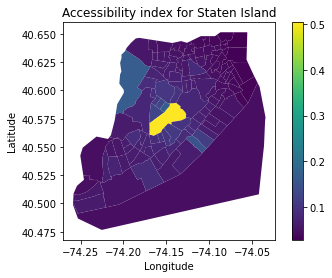

In [38]:
staten.plot_accessibility('Staten Island')

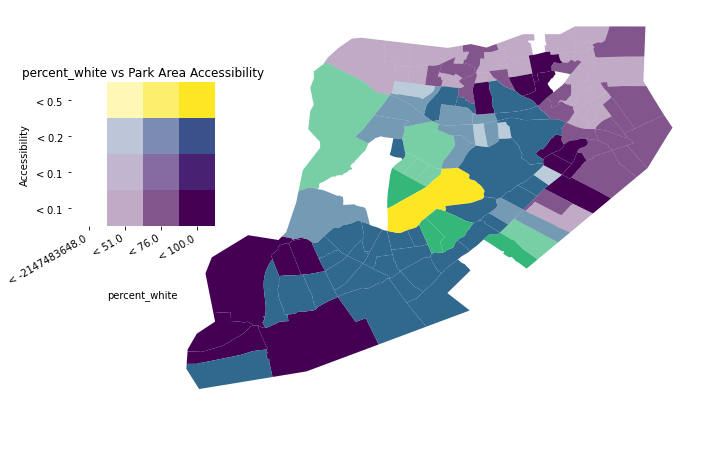

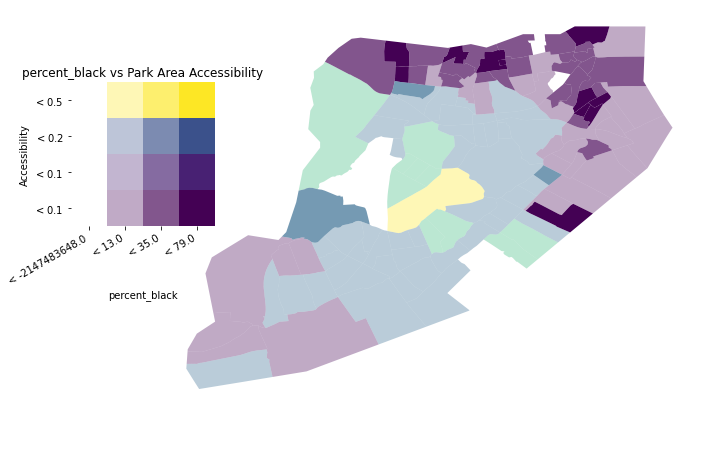

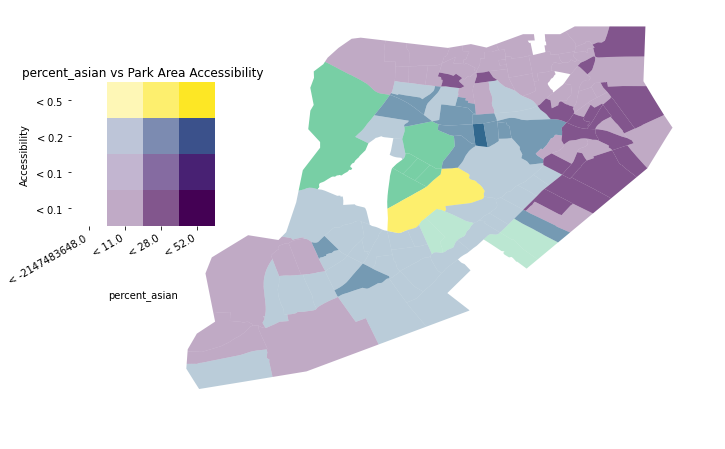

In [39]:
staten.plot_bivariate()

0.001 0.315946096341864


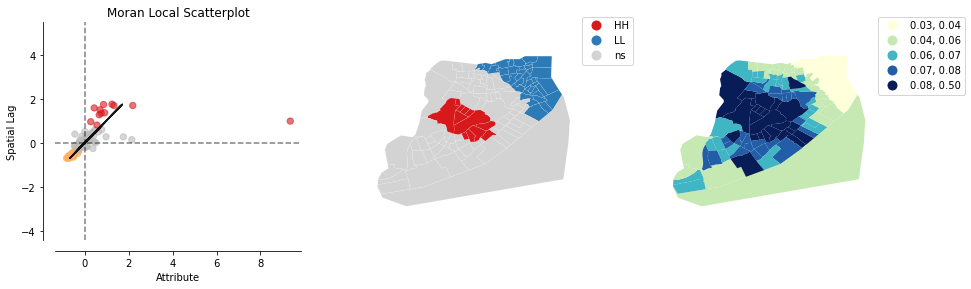

In [40]:
staten.moransI()

In [41]:
queens=nyc_parks(tracts, parks3, nyc_acs)

In [42]:
queens.calc_accessibility('081')

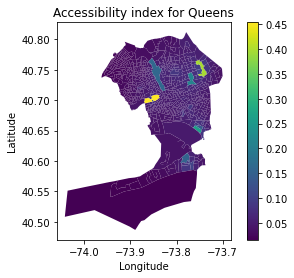

In [43]:
queens.plot_accessibility('Queens')

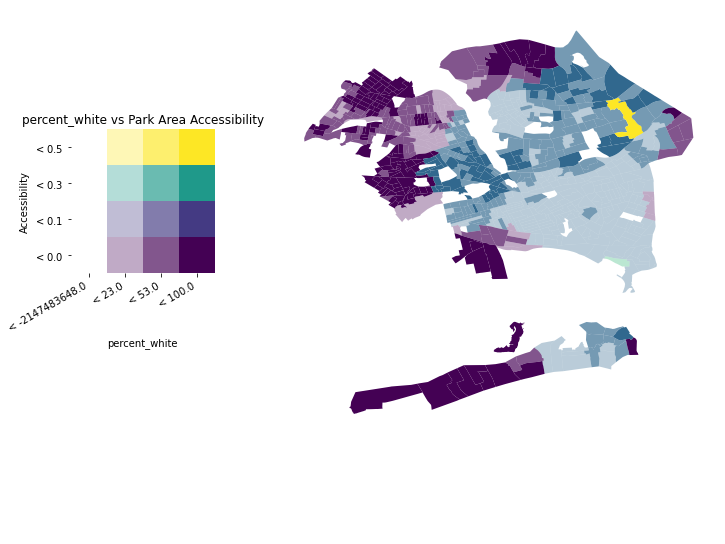

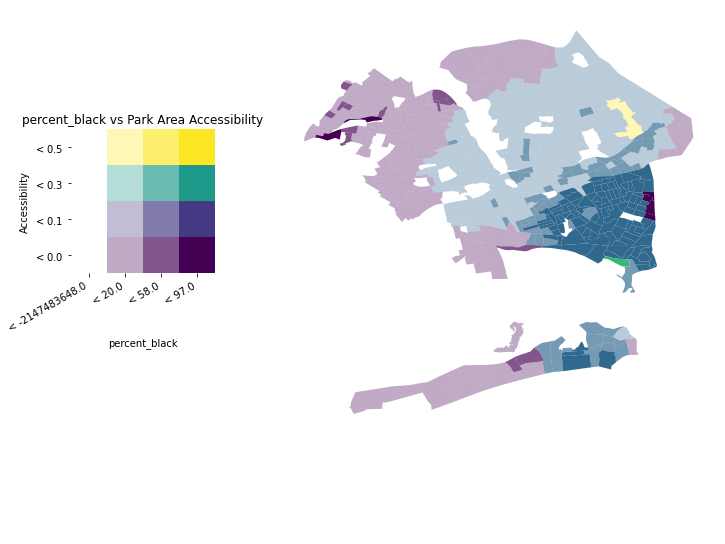

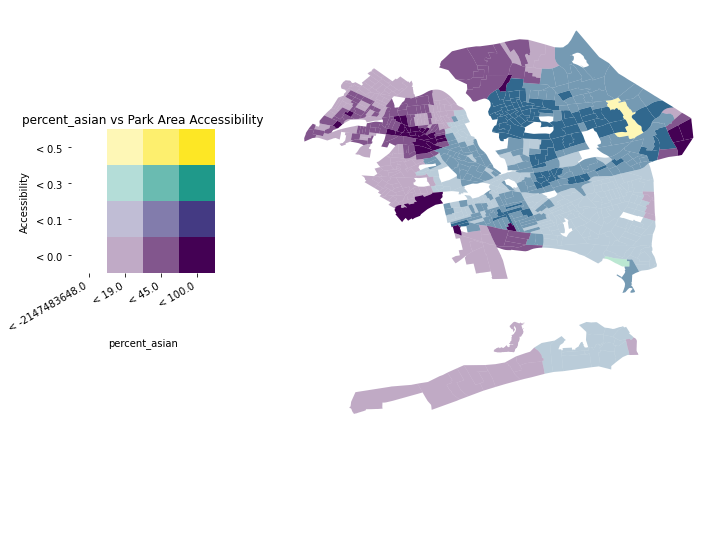

In [44]:
queens.plot_bivariate()

0.001 0.337711667219722


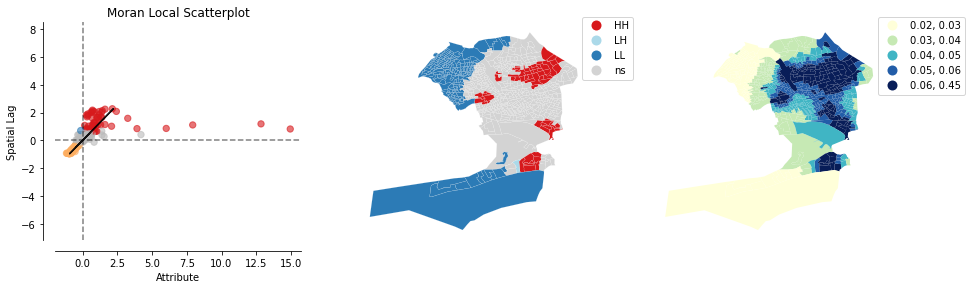

In [45]:
queens.moransI()